First, import packages and declare functions to use later.

In [1]:
PMID_regex = r'PMID[- ]*?(\d+)'
abstract_regex = r'AB  - ([\s\S]*?)FAU'
mesh_terms_regex = r'\nMH[\s-]+([\w\-\*\,\/\ ]+)'

import re
import statistics
import operator
from apyori import apriori
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def getMESHterms(medline, ignoreTerms = {}):
    # List of MeSH terms
    mesh_terms = re.findall(mesh_terms_regex, medline)
    toRemove = []
    for term in mesh_terms:
        if term in ignoreTerms:
            toRemove.append(term)
    for each in toRemove:
        mesh_terms.remove(each)
    for i in range(0, len(mesh_terms)):
        if re.search('(.+?)[\/,]', mesh_terms[i]):
            mesh_terms[i] = re.findall('(.+?)[\/,]', mesh_terms[i])[0]
    return mesh_terms

class PubMedCaseReport:
    def __init__(self, casereport, mesh=False, ab=False):
        self.pmid = int(re.search(PMID_regex, casereport)[1])
        self.MESH_terms = []
        if mesh:
            self.MESH_terms = getMESHterms(casereport)
        self.abstract = None
        if ab and re.search(abstract_regex, casereport):
            abstract = re.search(abstract_regex, casereport)[1]
            abstract = re.sub(r'\n', ' ', abstract)
            self.abstract = re.sub(r'\s{2,}', ' ', abstract)

Second, read in the ACCR case reports, gather up the MESH terms, how frequently they occur, and filter out the terms that appear "too often" or "too little".  Then we run the apriori algorithm on the MESH terms for the case reports and see what associations come up frequently, and narrow down the list to 2-term associations for the visualization.  Finally, we get a count of how many 2-item associations each MESH term in our whole set appears.

In [2]:
with open('ACCR.txt', 'r', encoding="utf8") as f:
    data = f.read()
f.close()

caseReports = data.split('\n\n')

mesh_terms = [getMESHterms(casereport) for casereport in caseReports]
pubmed_classes = [PubMedCaseReport(casereport, True) for casereport in caseReports]

term_counts = {}
for terms in mesh_terms:
    for term in terms:
        if term in term_counts:
            term_counts[term] += 1
        else:
            term_counts[term] = 1

count_distribution = []
for each in term_counts:
    count_distribution.append(term_counts[each])

avg_appearance = statistics.mean(count_distribution)
std_dev = statistics.stdev(count_distribution)
extreme_occurrance_terms = {}
for term in term_counts:
    if term_counts[term] > avg_appearance + 5*std_dev or term_counts[term] < avg_appearance:
        extreme_occurrance_terms[term] = term_counts[term]

filtered_mesh_terms = []
for report in caseReports:
    if getMESHterms(report, extreme_occurrance_terms):
        filtered_mesh_terms.append(getMESHterms(report, extreme_occurrance_terms))

results = list(apriori(filtered_mesh_terms, min_support = .005, min_lift = 1.5))
results_2x2 = [group for group in results if len(group.items) == 2]

frequency_counts = {}
for each in results_2x2:
    for term in each.items:
        if term in frequency_counts:
            frequency_counts[term] += 1
        else:
            frequency_counts[term] = 1
"""
frequency_counts_sorted = sorted(frequency_counts.items(), key=operator.itemgetter(1), reverse=True)
print('Total MESH terms:', len(frequency_counts_sorted))
for each in frequency_counts_sorted:
    print(each[1], each[0])
print(avg_appearance)
print(statistics.median(count_distribution))
print(std_dev)
"""

"\nfrequency_counts_sorted = sorted(frequency_counts.items(), key=operator.itemgetter(1), reverse=True)\nprint('Total MESH terms:', len(frequency_counts_sorted))\nfor each in frequency_counts_sorted:\n    print(each[1], each[0])\nprint(avg_appearance)\nprint(statistics.median(count_distribution))\nprint(std_dev)\n"

Third, we look at associations with MESH terms that appear at least twice.

In [3]:
filtered_2x2_results = []
for each in results_2x2:
    add_association = True
    for term in each.items:
        if frequency_counts[term] < 2:
            add_association = False
            break
    if add_association:
        filtered_2x2_results.append(each)
    add_association = False
print(len(filtered_2x2_results))

73


### Heatmap for Confidence

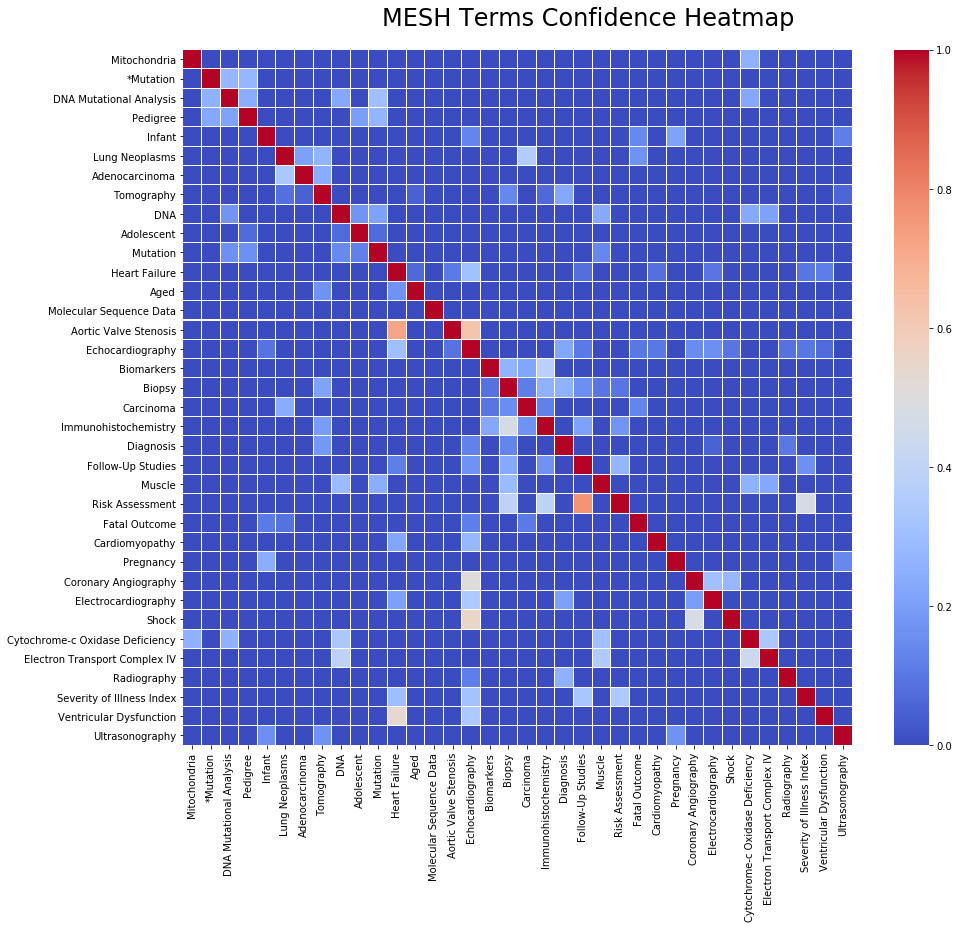

In [4]:
mesh_terms = [term for term in frequency_counts if frequency_counts[term] > 1]
association_confidence = pd.DataFrame(index=mesh_terms, columns=mesh_terms)
association_confidence = association_confidence.fillna(0) # with 0s rather than NaNs
for term in mesh_terms:
    association_confidence.loc[term, term] = 1
for result in filtered_2x2_results:
    for ordered_stat in result.ordered_statistics:
        base = list(ordered_stat.items_base)[0]
        add = list(ordered_stat.items_add)[0]
        association_confidence.loc[base, add] = ordered_stat.confidence

f, ax = plt.subplots(figsize=(15, 12))
hm_confidence = sns.heatmap(association_confidence, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t_confidence = f.suptitle('MESH Terms Confidence Heatmap', fontsize=24)
f.savefig('MESH_confidence.png', dpi=300, bbox_inches='tight')
plt.show()

### Heatmap for Lift

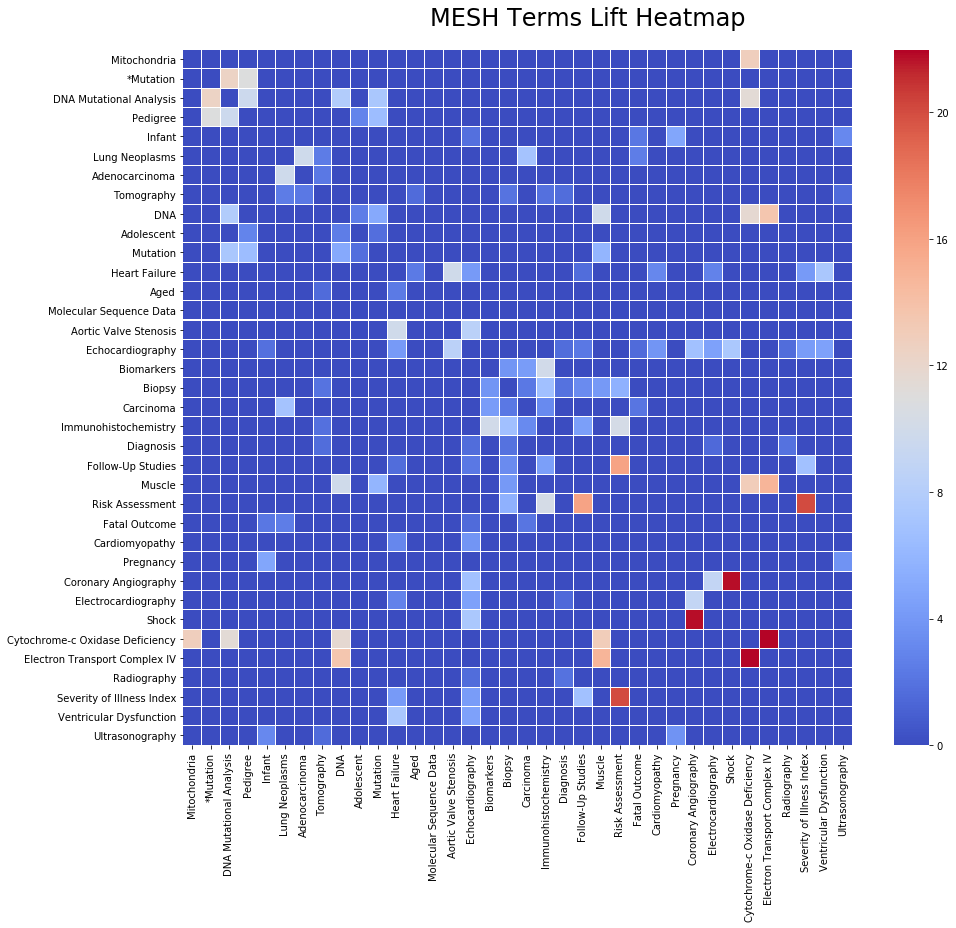

In [5]:
association_lift = pd.DataFrame(index=mesh_terms, columns=mesh_terms)
association_lift = association_lift.fillna(0)
for term in mesh_terms:
    association_lift.loc[term, term] = 0
for result in filtered_2x2_results:
    for ordered_stat in result.ordered_statistics:
        base = list(ordered_stat.items_base)[0]
        add = list(ordered_stat.items_add)[0]
        association_lift.loc[base, add] = ordered_stat.lift

g, ax = plt.subplots(figsize=(15, 12))
hm_lift = sns.heatmap(association_lift, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
g.subplots_adjust(top=0.93)
t_lift = g.suptitle('MESH Terms Lift Heatmap', fontsize=24)
plt.show()
g.savefig('MESH_lift.png', dpi=300, bbox_inches='tight')


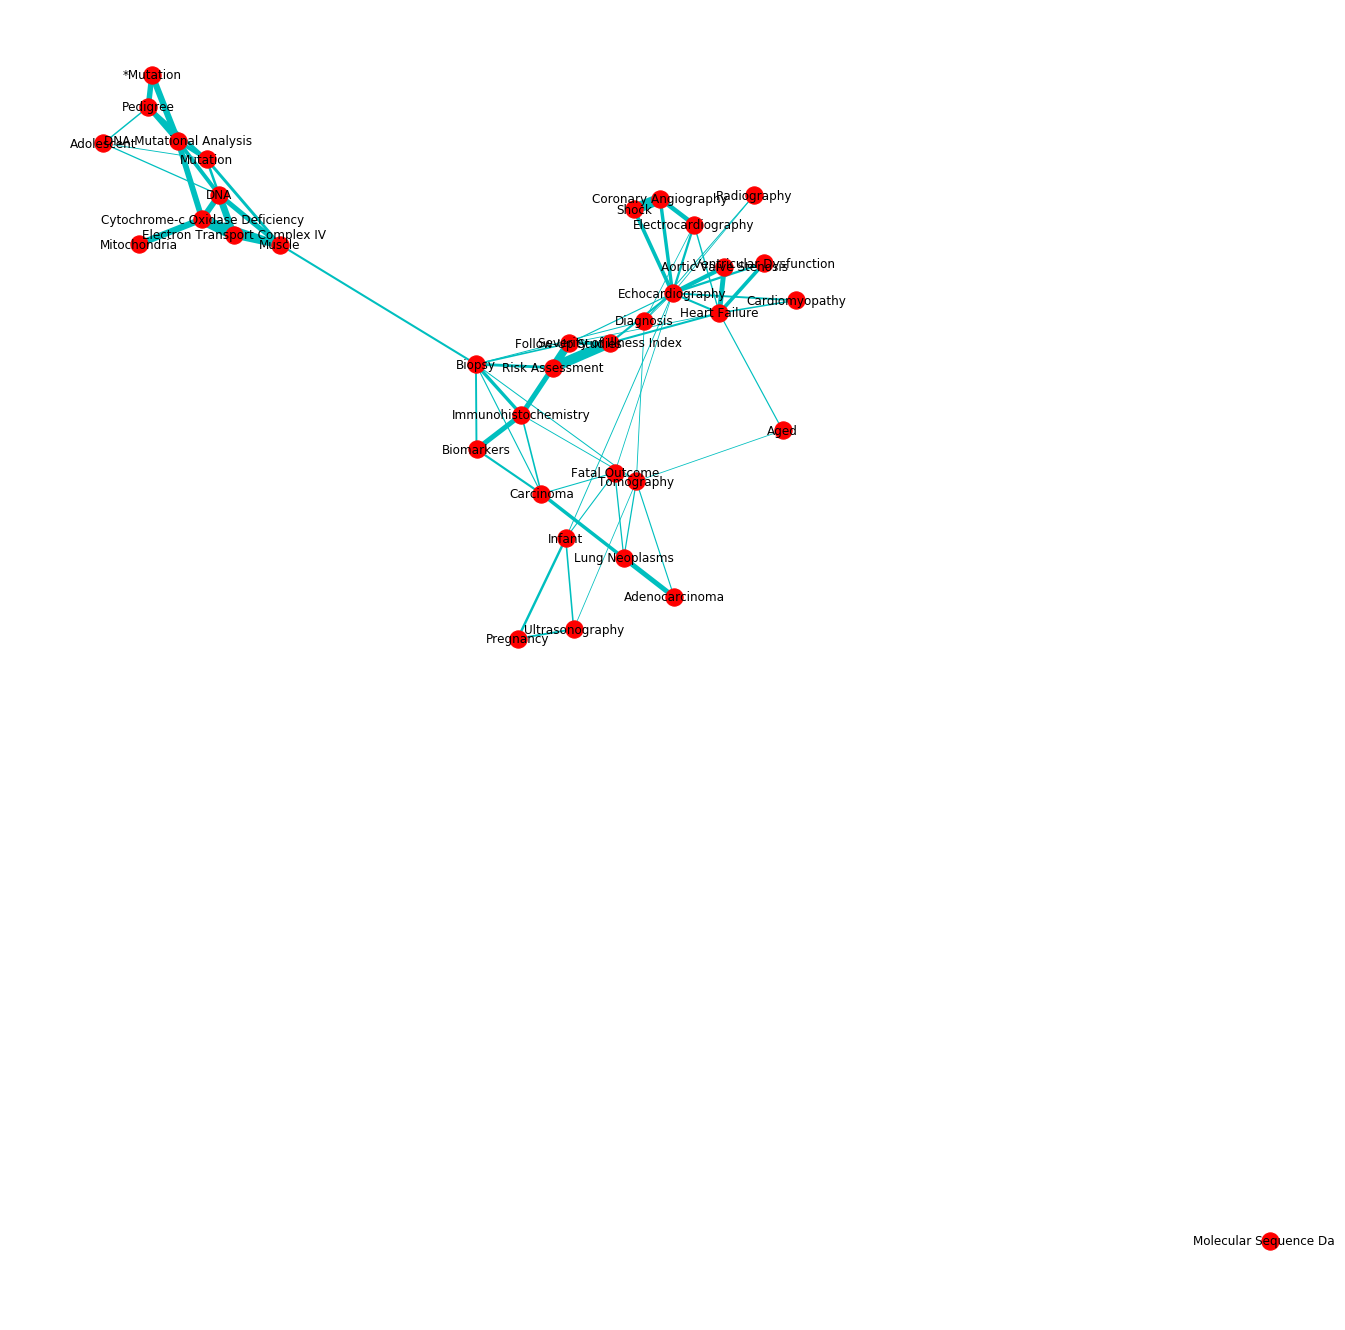

In [15]:
import networkx as nx
distances = pd.DataFrame(index=mesh_terms, columns=mesh_terms)

G = nx.Graph()
G.add_nodes_from(mesh_terms)
plt.figure(1, figsize=(18,18))
for result in filtered_2x2_results:
    for ordered_stat in result.ordered_statistics:
        base = list(ordered_stat.items_base)[0]
        add = list(ordered_stat.items_add)[0]
        G.add_edge(base, add, color='c', weight=ordered_stat.lift/2.0)
edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]
nx.draw(G, edges=edges, edge_color=colors, width=weights, with_labels=True, font_weights='bold')
plt.show()